# Introduction

*spotter* is a package to compute approximate forward models of fluxes and spectra time-series of non-uniform stars. 

Its main advantage over other frameworks is its capability to model small scale features thanks to the surface being subdivided into equal-area pixels. In order to do that, *spotter* exploits the  [HEALPix](https://HEALPix.jpl.nasa.gov/) subdivision scheme (through the python package [*healpy*](https://healpy.readthedocs.io/en/latest/)).

## HEALPix maps
Using healpy, a stellar surface simply consists in an array of values, one for each pixel. Let's create a random HEALPix map and show it.


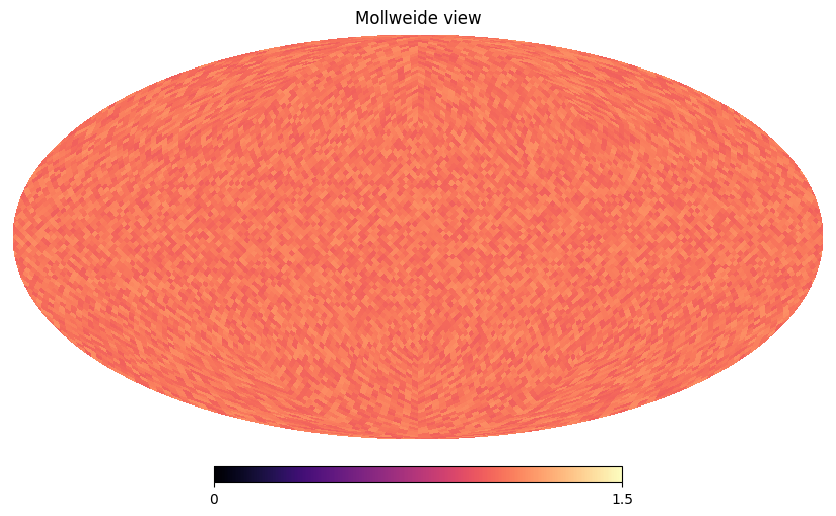

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

N = 2**5  # HEALPix map sides
n = hp.nside2npix(N)  # number of pixels
y = 1 + np.random.rand(n) * 0.15  # the map

hp.mollview(y, min=0, max=1.5, cmap="magma")

## Star object

We can define a [Star](spotter.star.Star) object that will contain the map of the star plus some of its parameter such as limb darkening and inclination

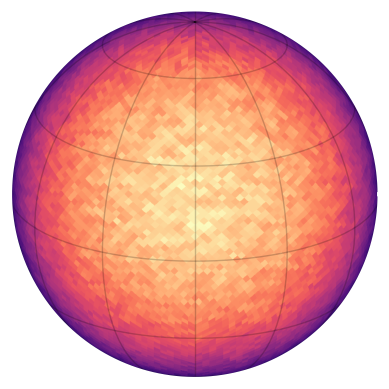

In [2]:
from spotter import Star, show

star = Star(y, u=(0.5, 0.2), inc=1.2, period=1.0)
show(star)

## Spots and faculae

Let's define a map with some spots

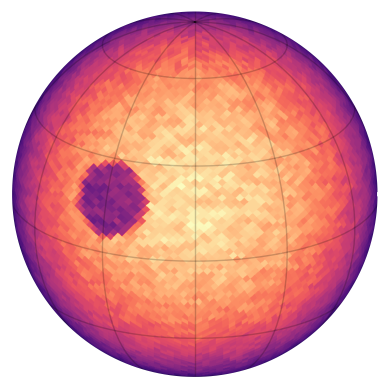

In [3]:
from spotter.core import spot

star = star - spot(y, 0.3, 0.5, 0.2) * 0.4

show(star)

and some faculae

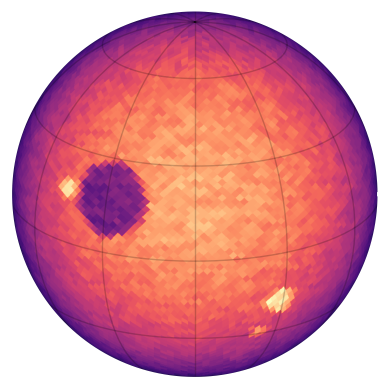

In [4]:
faculae = np.sum(
    [
        spot(y, 0.3, 0.8, 0.06) * 0.3 * y,
        spot(y, -0.3, -0.5, 0.08) * 0.35 * y,
        spot(y, -0.5, -0.4, 0.04) * 0.3 * y,
    ],
    0,
)

star = star + faculae

show(star)

## Light curves

We can also compute the light curve of this map

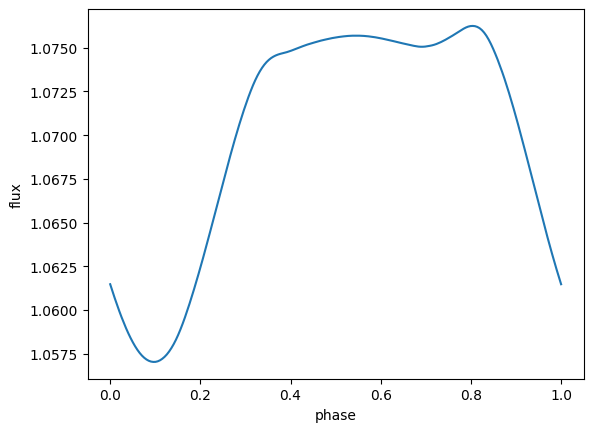

In [5]:
import jax
from spotter.light_curves import light_curve

time = np.linspace(0, 1, 200)

plt.plot(time, light_curve(star, time)[0])
plt.xlabel("phase")
_ = plt.ylabel("flux")

```{note}
All functions in *spotter* are carefully implemented with [JAX](https://jax.readthedocs.io/en/latest/quickstart.html), meaning that they can be vectorized and run on GPUs. For example this could be useful to evaluate the flux of a very large number of maps.
```

## JAX

Using [JAX](https://jax.readthedocs.io/en/latest/quickstart.html), other observables can be obtained in no time. For example

In [6]:
from spotter import distributions
from spotter.core import amplitude

# generate maps with a single random spot
n_spots = 500
latlon = distributions.uniform(n_spots)
radii = np.random.uniform(0.01, 0.9, n_spots)
contrast = np.random.uniform(0.01, 0.9, n_spots)
ys = 1 - jax.vmap(jax.jit(spot, static_argnums=(0,)), in_axes=(None, 0, 0, 0))(
    N, *latlon, radii
)

amplitude = jax.jit(amplitude(N, u=star.u[0]))
values = amplitude(ys)

Here we evaluated the amplitude of the rotational light curves of 500 maps, each containing a single random spot. Let's estimate the processing time of this computation

In [7]:
%timeit amplitude(ys)

4.5 ms ± 119 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


i.e. about tens of $\mu s$ per unique map!

```{note}
Notice here how we didn't use the `Star` object at all. Sometimes, especially when dealing with a large number of stars, the [Star](spotter.star.Star) object is not as optimal as working directly with the stellar maps, especially when using JAX transforms.
```

## Transiting exoplanets

### Stellar contamination

Other features of *spotter* are useful to compute the spot coverage, either of the map itself

In [8]:
# trivial
spotted = star.y < 1.0
coverage = np.mean(spotted)

print(f"coverage: {coverage * 100:.2f}%")

coverage: 1.00%


or within a specific transit chord

chord coverage: 13.56%


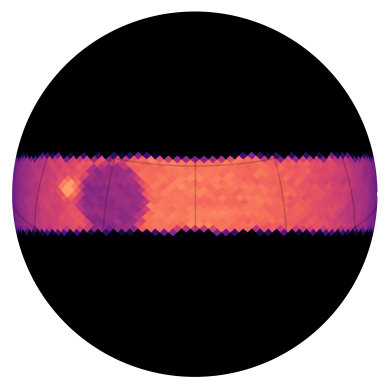

In [9]:
from spotter.core import mask_projected_limb, transit_chord, vec

transit = transit_chord(N, 0.0, 0.2, star.inc)

mask, area, _ = mask_projected_limb(vec(N), u=star.u[0], inc=star.inc)

spotted = (star.y[0] < 1.0) * mask
transited = transit * mask > 0.0

# let's show the chord
show(star * transited, vmin=0.0, vmax=1.5)

# covering fraction in the chord
chord_coverage = (spotted * transited * area).sum() / (transited * area).sum()
print(f"chord coverage: {chord_coverage * 100:.2f}%")

which is useful to compute transmission spectroscopy stellar contamination effects (the real motive of the *spotter* development).

### Transit light curve

Transited stars can also be modeled

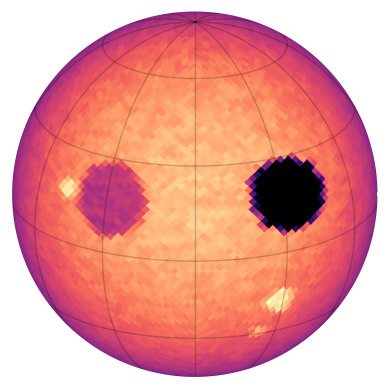

In [10]:
from spotter.star import transited_star

show(transited_star(star, y=0.5, r=0.2))

and their transit computed with

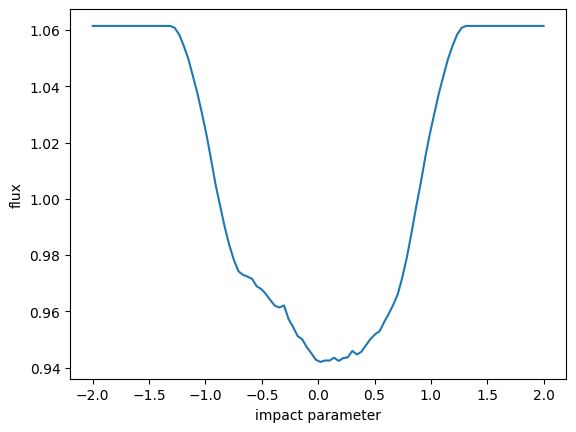

In [11]:
from spotter.light_curves import transit_light_curve

# impact parameter
b = np.linspace(-2, 2, 100)

flux = jax.vmap(lambda b: transit_light_curve(star, y=b, r=0.3)[0])(b)
plt.plot(b, flux)
plt.xlabel("impact parameter")
_ = plt.ylabel("flux")

```{important}
As you can see the transit light curve model contains errors due to the pixelization of the star. For this reason, we recommend to avoid using spotter as a transit model (e.g. to perform inferrence) but instead as an approximate forward model.
```